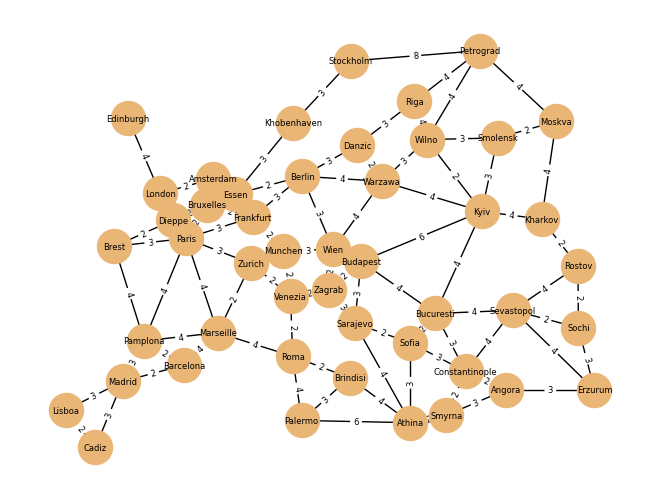

In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np


G = nx.Graph()
cities = pd.read_csv('cities.csv', index_col=0).to_dict(orient='index')
routes = pd.read_csv('routes.csv')
destinations = pd.read_csv('destinations.csv')

# Parcourir les lignes du DataFrame
for index, row in routes.iterrows():
    source = row['Source']
    target = row['Target']
    carriages = row['Weight']
    colored = row['Colored']
    tunnel = row['Tunnel']
    engines = row['Engine']
    G.add_edge(source, target, carriages=carriages, colored=colored, tunnel=tunnel, engines=engines, importance=0)

#Show graph
positions = {city:(pos['Longitude'],pos['Latitude']) for city,pos in cities.items()}


#Affichage du graphe
nx.draw(G,positions,node_size=600,font_size = 6, node_color='#eab676',with_labels=True)

#Ecriture des poids
edge_labels = {(u, v): d['carriages'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_size=6,font_color='black', label_pos=0.5)

plt.show()

In [4]:
# for u, v, attrs in G.edges(data=True):
#     print(f'Arête entre {u} et {v}:')
#     for attr, value in attrs.items():
#         print(f'{attr}: {value}')
#     print() 
# list(G.neighbors('Danzic'))
# # Compute the shortest path using Dijkstra's algorithm
# shortest_path = nx.shortest_path(G, source="Cadiz", target="Stockholm", weight="weight")
# # Calculate the total weight of the shortest path
# total_weight = nx.shortest_path_length(G, source="Cadiz", target="Stockholm", weight="weight")
# print("Shortest Path:", shortest_path)
# print("Total Weight:", total_weight)
# Compute the shortest path and its weights using Dijkstra's algorithm from node "A"
# source_node = "A"
# shortest_paths, shortest_path_lengths = nx.single_source_dijkstra(G, source=source_node, weight="weight")

# # Get the shortest path to a specific target node (e.g., "E")
# target_node = "E"
# shortest_path = shortest_paths[target_node]
# total_weight = shortest_path_lengths[target_node]

# print("Shortest Path:", shortest_path)
# print("Total Weight:", total_weight)
# destinations.loc[0, 'Source']
# destinations.head()

### Calcul des côuts de chaque ligne

In [5]:
weight_value = {1:1,2:2,3:4,4:7,6:13,8:21}

def cost(carriages,colored,tunnel,engines):
    weight = weight_value[carriages]
    weight = weight*1.3 if colored else weight
    weight = weight*1.2 if tunnel else weight
    weight = weight + engines*1.1
    return weight

def utility(min_dist, opt_dist, points):
    return np.exp(-opt_dist/min_dist)*points

for u, v, attrs in G.edges(data=True):
    attrs['cost'] = cost(attrs['carriages'], attrs['colored'], attrs['tunnel'], attrs['engines'])
    attrs['utility'] = 0

### Utilité à partir de toutes les cartes destinations

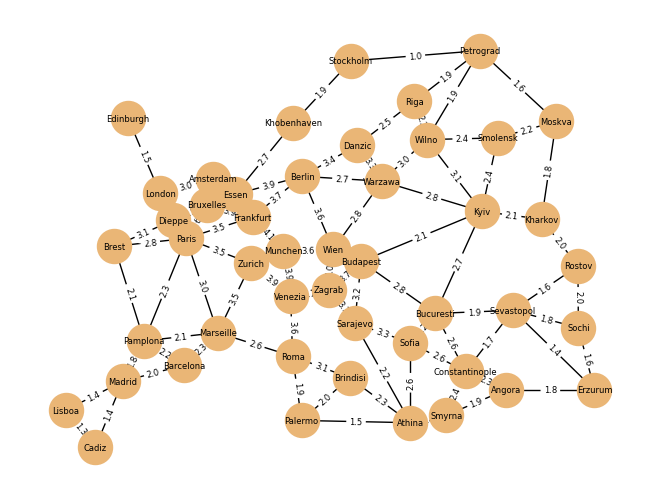

In [6]:
for _ , row in destinations.iterrows():
    source = row['Source']
    target = row['Target']
    points = row['Points']
    min_lengths_source, _ = nx.single_source_dijkstra(G, source=source, weight="cost")
    min_lengths_target, _ = nx.single_source_dijkstra(G, source=target, weight="cost")
    min_dist = min_lengths_source[target]
    for u, v, attrs in G.edges(data=True):
        opt_dist = min(min_lengths_source[u]+min_lengths_target[v],min_lengths_source[v]+min_lengths_target[u])+attrs['cost']
        attrs['utility'] = attrs['utility'] + utility(min_dist, opt_dist, points)

min_ = min(nx.get_edge_attributes(G, "utility").values())
for u, v, attrs in G.edges(data=True):
    attrs['utility'] = np.round(attrs['utility']/min_,1)

#Affichage du graphe
nx.draw(G,positions,node_size=600,font_size = 6, node_color='#eab676',with_labels=True)

#Ecriture des poids
edge_labels = {(u, v): d['utility'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_size=6,font_color='black', label_pos=0.5)

plt.show()

Carriages
2    33
3    26
4    25
1     3
6     2
8     1
Name: count, dtype: int64


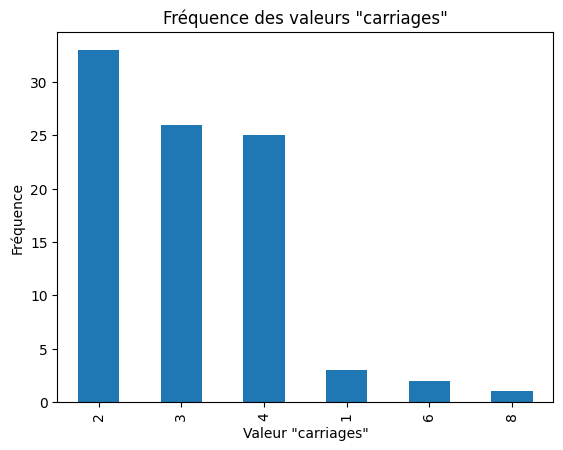

In [8]:
# Créez un DataFrame à partir des attributs "carriages" du graphe
carriages_data = pd.DataFrame([(u, v, attrs['carriages']) for u, v, attrs in G.edges(data=True)],
                              columns=['Source', 'Target', 'Carriages'])
print(carriages_data['Carriages'].value_counts())
# Créez un histogramme des valeurs "carriages"
carriages_data['Carriages'].value_counts().plot(kind='bar')

plt.xlabel('Valeur "carriages"')
plt.ylabel('Fréquence')
plt.title('Fréquence des valeurs "carriages"')
plt.show()
